In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model


import dill

import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

Using Theano backend.


In [2]:
with open('tiffs.pkl', 'rb') as in_strm:
    all_info = dill.load(in_strm)

In [28]:
x_train = all_info[0]
x_test = all_info[1]
y_train = all_info[2]
y_test = all_info[3]

In [29]:
def flatten(matrix):
    vector = np.reshape(matrix, (matrix.shape[0], matrix.shape[1] * matrix.shape[2], matrix.shape[3]))
    return vector

In [30]:
x_train = flatten(x_train)
print(x_train.shape)
x_test = flatten(x_test)
print(x_test.shape)

(35000, 1024, 3)
(5479, 1024, 3)


In [31]:
def zero_mean(matrix):
    m = matrix.mean(axis=1)
    return matrix - m[:, np.newaxis]

In [32]:
x_train = zero_mean(x_train)
x_test = zero_mean(x_test)

In [33]:
x_train_red = x_train[:,:,0]
x_train_green = x_train[:,:,1]
x_train_blue = x_train[:,:,2]
x_test_red = x_test[:,:,0]
x_test_green = x_test[:,:,1]
x_test_blue = x_test[:,:,2]

In [34]:
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

applying zca to xtrain and xtest in batches of 1000 images

In [84]:
lst = list()
for i in range(3):
    processed_x_train_color = np.zeros((0, 1024))
    x_train_color = x_train[:,:,i]
    x_train_color_batches = np.split(x_train_color, 35)
    for batch in x_train_color_batches:
        zca_matrix = zca_whitening_matrix(batch)
        projection = np.dot(zca_matrix, batch)
        processed_x_train_color = np.vstack((processed_x_train_color, projection))
    lst.append(processed_x_train_color)
processed_x_train = np.dstack((np.dstack((lst[0], lst[1])), lst[2]))
        

In [86]:
x_test = x_test[:5000, :, :]
lst = list()
for i in range(3):
    processed_x_test_color = np.zeros((0, 1024))
    x_test_color = x_test[:,:,i]
    x_test_color_batches = np.split(x_test_color, 5)
    for batch in x_test_color_batches:
        zca_matrix = zca_whitening_matrix(batch)
        projection = np.dot(zca_matrix, batch)
        processed_x_test_color = np.vstack((processed_x_test_color, projection))
    lst.append(processed_x_test_color)
processed_x_test = np.dstack((np.dstack((lst[0], lst[1])), lst[2]))

In [92]:
y_test = y_test[:5000,:]
print(y_test.shape)

(5000, 17)


In [87]:
processed_x_train = np.reshape(processed_x_train, 
                               (processed_x_train.shape[0], 32, 32, 3))
processed_x_test = np.reshape(processed_x_test, 
                               (processed_x_test.shape[0], 32, 32, 3))
print(processed_x_train.shape)
print(processed_x_test.shape)

(35000, 32, 32, 3)
(5000, 32, 32, 3)


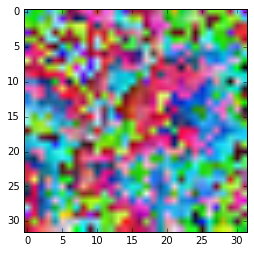

In [90]:
first_img = processed_x_train[5]
imgplot = plt.imshow(first_img)
plt.show()

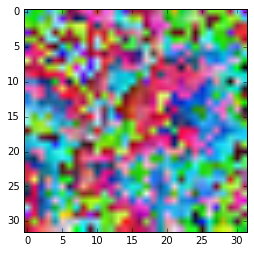

In [89]:
first_img_red = first_img[:,:,0]
imgplot = plt.imshow(first_img)
plt.show()

later: dont forget near infrared ??

In [52]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

In [81]:
def createFirstBatchBlocks(img):
    red = img[:,:,0]
    green = img[:,:,1]
    blue = img[:,:,2]
    toReshape = np.array([blockshaped(red, 8, 8), blockshaped(green, 8, 8),
                    blockshaped(blue, 8, 8)])
    return np.reshape(toReshape, (toReshape.shape[1], toReshape.shape[2],
                                 toReshape.shape[3], toReshape.shape[0]))
    

In [69]:
def createSecondBatchBlocks(img):
    cropped_red = img[4:28,4:28,0]
    cropped_green = img[4:28,4:28,1]
    cropped_blue = img[4:28,4:28,2]
    toReshape = np.array([blockshaped(cropped_red, 8, 8), blockshaped(cropped_green, 8, 8),
                    blockshaped(cropped_blue, 8, 8)])
    return np.reshape(toReshape, (toReshape.shape[1], toReshape.shape[2],
                                 toReshape.shape[3], toReshape.shape[0]))

In [77]:
def createSubSampledBlock(img):
    red = img[:,:,0]
    green = img[:,:,1]
    blue = img[:,:,2]
    subRed = red[::4,::4]
    subGreen = green[::4,::4]
    subBlue = blue[::4,::4]
    toReshape = np.array([subRed, subGreen, subBlue])
    return np.reshape(toReshape, (1, toReshape.shape[1],
                                 toReshape.shape[2], toReshape.shape[0]))

In [82]:
def createAllBlocks(img):
    firstBlocks = createFirstBatchBlocks(img)
    secondBlocks = createSecondBatchBlocks(img)
    lastBlock = createSubSampledBlock(img)
    return np.vstack((np.vstack((firstBlocks, secondBlocks)), lastBlock))

In [114]:
def createAllBlocksAllImages(imgs):
    blocksSoFar = []
    for i in range(imgs.shape[0]):
        img = imgs[i]
        allBlocks = createAllBlocks(img)
        blocksSoFar.append(allBlocks)
    return np.array(blocksSoFar)

If ever confused about block shape and labels shape, look here:

In [115]:
proc_x_train_blocks, createAllBlocksAllImages(processed_x_train)
proc_x_test_blocks, createAllBlocksAllImages(processed_x_test)
print(proc_x_train_blocks.shape)
print(proc_x_test_blocks.shape)

(35000, 26, 8, 8, 3)
(5000, 26, 8, 8, 3)


In [110]:
from sklearn.neural_network import BernoulliRBM

reshape for boltzman

In [ ]:
proc_x_train_blocks = np.reshape(proc_x_train_blocks, (proc_x_train_blocks.shape[0], 
                            proc_x_train_blocks.shape[1], proc_x_train_blocks.shape[2] *
                                proc_x_train_blocks.shape[3], proc_x_train_blocks.shape[4]))

training 3 separate boltzmanns for 3 separate colors

listOfBoltz is list of (list of 3 RBM's for each color of each block)

In [161]:
listOfBoltz = list()
for i in [25]:
    print("training rbm's for block number ", i)
    listOfColorBoltz = list()
    rbm_red = BernoulliRBM(n_components=300, random_state=0, 
                   verbose=True, learning_rate=0.0000001, n_iter=50)
    rbm_green = BernoulliRBM(n_components=300, random_state=0, 
                   verbose=True, learning_rate=0.0000001, n_iter=1)
    rbm_blue = BernoulliRBM(n_components=300, random_state=0, 
                   verbose=True, learning_rate=0.0000001, n_iter=1)
    red_imgs = proc_x_train_blocks[:,i,:,0]
    green_imgs = proc_x_train_blocks[:,i,:,1]
    blue_imgs = proc_x_train_blocks[:,i,:,2]
    rbm_red.fit(red_imgs, y_train)
    rbm_green.fit(green_imgs, y_train)
    rbm_blue.fit(blue_imgs, y_train)
    listOfColorBoltz.append(rbm_red)
    listOfColorBoltz.append(rbm_green)
    listOfColorBoltz.append(rbm_blue)
    listOfBoltz.append(listOfColorBoltz)

training rbm's for block number  25
[BernoulliRBM] Iteration 1, pseudo-likelihood = -43.97, time = 3.84s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -43.56, time = 4.36s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -43.17, time = 4.24s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -42.78, time = 4.35s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -42.40, time = 4.24s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -42.03, time = 4.27s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -41.67, time = 4.30s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -41.32, time = 4.27s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -40.98, time = 4.12s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -40.65, time = 4.24s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -40.32, time = 4.09s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -40.01, time = 4.59s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -39.70, time = 4.09s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -39.39, time =

(300, 64)


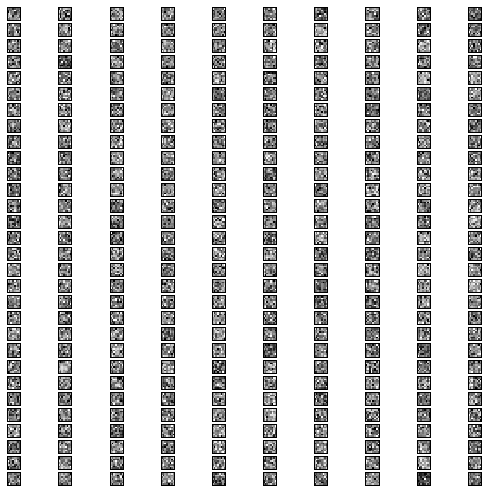

"\nfor i in range(redFirstBoltz.components_.shape[0]):\n    plt.subplot(25, 12, i + 1)\n    redWeights = redFirstBoltz.components_[i].reshape((8, 8))\n    #greenWeights = greenFirstBoltz.components_[i].reshape((8, 8))\n    #blueWeights = blueFirstBoltz.components_[i].reshape((8, 8))\n    #print(redWeights)\n    #finalWeights = np.array([redWeights, greenWeights, blueWeights]).reshape((8, 8, 3))\n    plt.imshow(redWeights, cmap=plt.cm.gray_r,\n               interpolation='nearest')\n    plt.xticks(())\n    plt.yticks(())\nplt.subplots_adjust(0.16, 0.04, 1.84, 1.7, 0.16, 0.46)\n\nplt.show()\n"

In [162]:
firstBlockBoltz = listOfBoltz[0]
#secondBlockBoltz = listOfBoltz[1]
redFirstBoltz = firstBlockBoltz[0]
greenFirstBoltz = firstBlockBoltz[1]
blueFirstBoltz = firstBlockBoltz[2]

print(redFirstBoltz.components_.shape)

plt.figure(figsize=(8.4, 8))
for i, comp in enumerate(redFirstBoltz.components_):
    #print(comp.shape)
    plt.subplot(30, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)),cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

'''
for i in range(redFirstBoltz.components_.shape[0]):
    plt.subplot(25, 12, i + 1)
    redWeights = redFirstBoltz.components_[i].reshape((8, 8))
    #greenWeights = greenFirstBoltz.components_[i].reshape((8, 8))
    #blueWeights = blueFirstBoltz.components_[i].reshape((8, 8))
    #print(redWeights)
    #finalWeights = np.array([redWeights, greenWeights, blueWeights]).reshape((8, 8, 3))
    plt.imshow(redWeights, cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.16, 0.04, 1.84, 1.7, 0.16, 0.46)

plt.show()
'''

oh, later keep the 256 x 256 image instead of 32 x 32...that will be annoying as fuck lol

Conclusion: Keeping things efficient / iterating quickly, so fuck unsupervised learning.
It also seems like DeepSat never used RBM's so I have no idea why I'm using this.
Things I've learned: it's good to swallow your pride and start over.
It also seems like the winners of the competition fuck up a lot at the start too.
And they implement many networks from literature, but only some work.